# Graph Neural Network (GNN) Models Tutorial

This notebook demonstrates how to:
1. Build a Drug-Target Affinity (DTA) dataset from ChEMBL
2. Train Graph Neural Networks on molecular graphs
3. Compare different GNN architectures
4. Extract molecule embeddings
5. Make predictions with trained GNN models

## Table of Contents
1. [Setup and Installation](#setup)
2. [Building a Dataset](#building-dataset)
3. [Understanding Molecular Graphs](#molecular-graphs)
4. [Training GNN Models](#training-gnn)
5. [Comparing Architectures](#comparing-architectures)
6. [Extracting Embeddings](#embeddings)
7. [Making Predictions](#predictions)
8. [Best Practices](#best-practices)

## 1. Setup and Installation {#setup}

First, ensure you have DTA-GNN installed with GNN dependencies:

```bash
pip install dta-gnn
```

This automatically installs PyTorch and PyTorch Geometric.

**Note**: For GPU acceleration:
- **NVIDIA GPU**: Install CUDA-enabled PyTorch
- **Apple Silicon (M1/M2/M3)**: MPS support is automatic
- **CPU**: Works but slower for training

DTA-GNN automatically detects and uses the best available device (MPS > CUDA > CPU).

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import json

# DTA-GNN imports
from dta_gnn.pipeline import Pipeline
from dta_gnn.models.gnn import (
    GnnTrainConfig,
    train_gnn_on_run,
    extract_gnn_embeddings_on_run,
    _get_device
)
from dta_gnn.models.predict import predict_with_gnn
from dta_gnn.io.runs import create_run_dir
from dta_gnn.visualization import plot_activity_distribution, plot_split_sizes
from dta_gnn.features.molecule_graphs import smiles_to_graph_2d

# Set style for plots (with fallback for compatibility)
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')
sns.set_palette("husl")

# Check available device
device = _get_device(None)
print(f"✓ All imports successful!")
print(f"✓ Using device: {device}")
print(f"  (MPS = Apple Silicon GPU, CUDA = NVIDIA GPU, CPU = CPU)")

✓ All imports successful!
✓ Using device: mps
  (MPS = Apple Silicon GPU, CUDA = NVIDIA GPU, CPU = CPU)


## 2. Building a Dataset {#building-dataset}

We'll build a dataset similar to the baseline tutorial, but this time we'll focus on preparing it for GNN training.

In [2]:
# Initialize pipeline (use Web API for this example, or SQLite for faster performance)
#pipeline = Pipeline(source_type="web")
pipeline = Pipeline(source_type="sqlite", sqlite_path="../chembl_dbs/chembl_36.db")

# Create run directory
run_dir = create_run_dir()
print(f"✓ Run directory: {run_dir}")

# Build dataset
print("\nBuilding dataset... This may take a few minutes with Web API...")

df = pipeline.build_dta(
    target_ids=["CHEMBL204"],  # Acetylcholinesterase
    standard_types=["IC50", "Ki", "Kd"],
    split_method="scaffold",  # Important: scaffold splitting prevents data leakage
    test_size=0.2,
    val_size=0.1,
    output_path=str(run_dir / "dataset.csv"),
    featurize=False  # GNNs use graph features, not fingerprints
)

# Save compounds (required for GNN training)
compounds = df[["molecule_chembl_id", "smiles"]].drop_duplicates()
compounds.to_csv(run_dir / "compounds.csv", index=False)

print(f"\n✓ Dataset ready!")
print(f"  Total samples: {len(df)}")
print(f"  Unique compounds: {len(compounds)}")
print(f"  Split distribution:")
print(df["split"].value_counts())

2026-01-25 14:23:20.340 | INFO     | dta_gnn.pipeline:build_dta:44 - Starting DTA build for targets: ['CHEMBL204']


✓ Run directory: runs/20260125_142320

Building dataset... This may take a few minutes with Web API...

✓ Dataset ready!
  Total samples: 7908
  Unique compounds: 7908
  Split distribution:
split
train    5536
test     1564
val       807
Name: count, dtype: int64


## 3. Understanding Molecular Graphs {#molecular-graphs}

GNNs work on **molecular graphs** where:
- **Nodes (Atoms)**: Represent atoms with 6D features (atomic number, degree, charge, H count, aromaticity, mass)
- **Edges (Bonds)**: Represent bonds with 6D features (bond type, aromaticity, conjugation, ring membership)

Let's visualize how SMILES are converted to graphs:

In [3]:
# Example: Convert a SMILES to a molecular graph
example_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"  # Aspirin
graph = smiles_to_graph_2d(molecule_chembl_id="aspirin", smiles=example_smiles)

if graph:
    print(f"✓ Graph created for: {example_smiles}")
    print(f"  Number of atoms (nodes): {len(graph.atom_type)}")
    print(f"  Number of bonds (edges): {graph.edge_index.shape[1] // 2}")  # Undirected, so divide by 2
    print(f"  Node features shape: {graph.atom_feat.shape}")  # [num_atoms, 6]
    print(f"  Edge features shape: {graph.edge_attr.shape}")  # [num_edges, 6]
    print(f"\n  Node features (first 3 atoms):")
    print(f"    {graph.atom_feat[:3]}")
    print(f"\n  Edge features (first 3 bonds):")
    print(f"    {graph.edge_attr[:3]}")
else:
    print("✗ Failed to create graph")

✓ Graph created for: CC(=O)OC1=CC=CC=C1C(=O)O
  Number of atoms (nodes): 13
  Number of bonds (edges): 13
  Node features shape: (13, 6)
  Edge features shape: (26, 6)

  Node features (first 3 atoms):
    [[ 6.     4.     0.     3.     0.    12.011]
 [ 6.     3.     0.     0.     0.    12.011]
 [ 8.     1.     0.     0.     0.    15.999]]

  Edge features (first 3 bonds):
    [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0.]]


## 4. Training GNN Models {#training-gnn}

DTA-GNN supports **10 GNN architectures**:
1. **GIN** (Graph Isomorphism Network) - Uses edge features
2. **GCN** (Graph Convolutional Network) - Classic message passing
3. **GAT** (Graph Attention Network) - Attention-based, uses edge features
4. **GraphSAGE** - Sampling and aggregation
5. **PNA** (Principal Neighbourhood Aggregation) - Advanced aggregation, uses edge features
6. **Transformer** - Self-attention mechanism, uses edge features
7. **TAG** (Topology Adaptive Graph) - K-hop message passing
8. **ARMA** (AutoRegressive Moving Average) - Recurrent-style
9. **Cheb** (Chebyshev) - Spectral convolution
10. **SuperGAT** - Supervised attention

### Step 4.1: Train a GIN Model (Recommended Starting Point)

GIN is a good starting architecture because:
- Uses both node and edge features
- Strong theoretical foundation
- Good performance on molecular graphs

In [4]:
# Configure GNN training
gnn_config = GnnTrainConfig(
    architecture="gin",  # Graph Isomorphism Network
    epochs=5,  # Number of training epochs
    batch_size=64,  # Batch size (adjust based on GPU memory)
    embedding_dim=128,  # Final molecule embedding dimension
    hidden_dim=128,  # Hidden layer dimension
    num_layers=2,  # Number of GNN layers
    dropout=0.1,  # Dropout rate
    pooling="attention",  # Graph pooling: add, mean, max, or attention
    residual=True,  # Residual connections
    lr=1e-3,  # Learning rate
    # GIN-specific parameters
    gin_conv_mlp_layers=2,  # MLP depth in GIN convolution
    gin_train_eps=False,  # Whether to learn epsilon parameter
    gin_eps=0.0,  # Initial epsilon value
    device=None,  # Auto-detect: MPS > CUDA > CPU
)

print("GNN Configuration:")
print(f"  Architecture: {gnn_config.architecture}")
print(f"  Epochs: {gnn_config.epochs}")
print(f"  Batch size: {gnn_config.batch_size}")
print(f"  Hidden dim: {gnn_config.hidden_dim}")
print(f"  Embedding dim: {gnn_config.embedding_dim}")
print(f"  Layers: {gnn_config.num_layers}")
print(f"  Pooling: {gnn_config.pooling}")
print(f"  Device: {device}")

GNN Configuration:
  Architecture: gin
  Epochs: 5
  Batch size: 64
  Hidden dim: 128
  Embedding dim: 128
  Layers: 2
  Pooling: attention
  Device: mps


In [5]:
# Train the GNN model
print("Training GNN model...")
print("This may take several minutes depending on dataset size and device...\n")

gnn_result = train_gnn_on_run(
    run_dir=run_dir,
    config=gnn_config
)

print(f"\n✓ Training completed!")
print(f"  Task type: {gnn_result.task_type}")
print(f"  Model saved to: {gnn_result.model_path}")
print(f"  Encoder saved to: {gnn_result.encoder_path}")
print(f"  Metrics saved to: {gnn_result.metrics_path}")
print(f"  Predictions saved to: {gnn_result.predictions_path}")

Training GNN model...
This may take several minutes depending on dataset size and device...


✓ Training completed!
  Task type: regression
  Model saved to: runs/20260125_142320/model_gnn_gin.pt
  Encoder saved to: runs/20260125_142320/encoder_gin.pt
  Metrics saved to: runs/20260125_142320/model_metrics_gnn_gin.json
  Predictions saved to: runs/20260125_142320/model_predictions_gnn_gin.csv


In [6]:
# Load and display metrics
with open(gnn_result.metrics_path, 'r') as f:
    gnn_metrics = json.load(f)

print("GNN Performance Metrics:")
print("=" * 60)


for split_name, split_metrics in gnn_metrics.get("splits", {}).items():
    print(f"\n{split_name.upper()} Set:")
    rmse = split_metrics.get('rmse')
    mae = split_metrics.get('mae')
    r2 = split_metrics.get('r2')
    pearson_r = split_metrics.get('pearson_r')
    
    print(f"  RMSE: {rmse:.4f}" if isinstance(rmse, (int, float)) else "  RMSE: N/A")
    print(f"  MAE: {mae:.4f}" if isinstance(mae, (int, float)) else "  MAE: N/A")
    print(f"  R²: {r2:.4f}" if isinstance(r2, (int, float)) else "  R²: N/A")
    print(f"  Pearson R: {pearson_r:.4f}" if isinstance(pearson_r, (int, float)) else "  Pearson R: N/A")

GNN Performance Metrics:

TEST Set:
  RMSE: 1.6176
  MAE: 1.3219
  R²: 0.0886
  Pearson R: N/A

TRAIN Set:
  RMSE: 1.5466
  MAE: 1.2612
  R²: 0.1505
  Pearson R: N/A

VAL Set:
  RMSE: 1.4353
  MAE: 1.1627
  R²: 0.0499
  Pearson R: N/A


Available columns in predictions file: ['molecule_chembl_id', 'target_chembl_id', 'label', 'split', 'y_pred']

Number of predictions: 2371


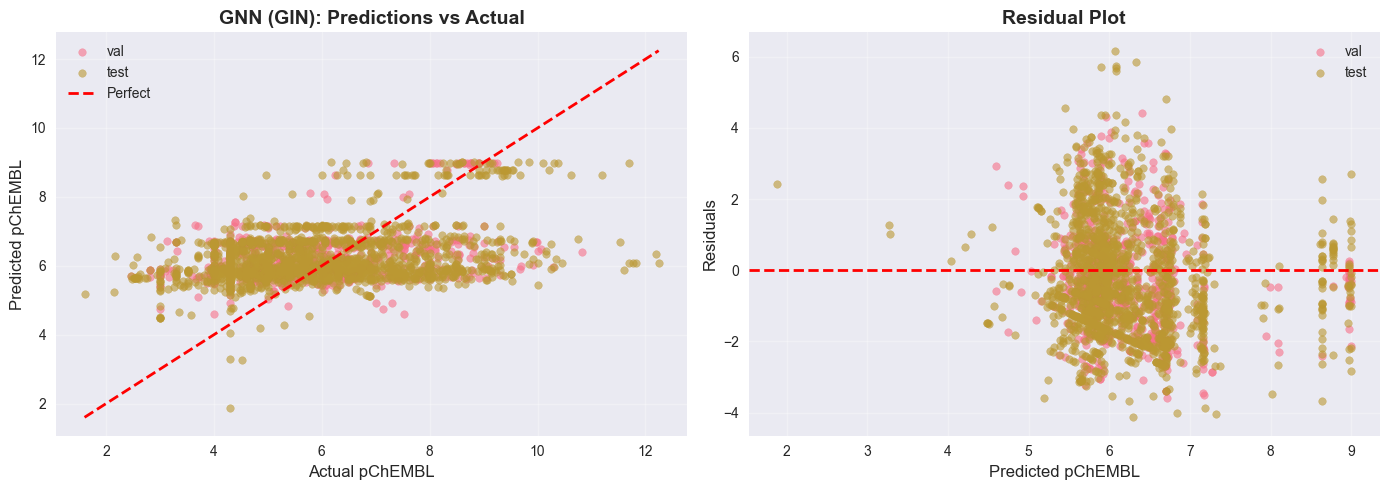

In [7]:
# Visualize predictions
preds_df = pd.read_csv(gnn_result.predictions_path)

# Check available columns (for debugging)
print("Available columns in predictions file:", preds_df.columns.tolist())
print(f"\nNumber of predictions: {len(preds_df)}")

if gnn_result.task_type == "regression":
    # The predictions CSV contains 'label' (true values) and 'y_pred' (predictions)
    # Note: predictions file contains val/test splits
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Predictions vs actual
    for split in ["val", "test"]:  # Predictions file contains val and test
        split_data = preds_df[preds_df["split"] == split]
        if len(split_data) > 0:
            axes[0].scatter(
                split_data["label"],  # True values are in 'label' column
                split_data["y_pred"], 
                alpha=0.6, 
                label=split,
                s=30
            )
    
    if len(preds_df) > 0:
        min_val = min(preds_df["label"].min(), preds_df["y_pred"].min())
        max_val = max(preds_df["label"].max(), preds_df["y_pred"].max())
        axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    axes[0].set_xlabel("Actual pChEMBL", fontsize=12)
    axes[0].set_ylabel("Predicted pChEMBL", fontsize=12)
    axes[0].set_title(f"GNN ({gnn_config.architecture.upper()}): Predictions vs Actual", fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residual plot
    for split in ["val", "test"]:
        split_data = preds_df[preds_df["split"] == split]
        if len(split_data) > 0:
            residuals = split_data["label"] - split_data["y_pred"]
            axes[1].scatter(split_data["y_pred"], residuals, alpha=0.6, label=split, s=30)
    
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel("Predicted pChEMBL", fontsize=12)
    axes[1].set_ylabel("Residuals", fontsize=12)
    axes[1].set_title("Residual Plot", fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [8]:
### Step 5.1: Train a GAT Model for Comparison
gat_config = GnnTrainConfig(
    architecture="gat",  # Graph Attention Network
    epochs=5,
    batch_size=64,
    embedding_dim=128,
    hidden_dim=128,
    num_layers=2,
    dropout=0.1,
    pooling="attention",
    residual=True,
    lr=1e-3,
    # GAT-specific parameters
    gat_heads=2,  # Number of attention heads
    device=None,
)

print("Training GAT model for comparison...")
gat_result = train_gnn_on_run(run_dir=run_dir, config=gat_config)

# Load GAT metrics
with open(gat_result.metrics_path, 'r') as f:
    gat_metrics = json.load(f)

# Compare architectures
print("\n" + "=" * 60)
print("Architecture Comparison")
print("=" * 60)

gin_test = gnn_metrics.get("splits", {}).get("test", {})
gat_test = gat_metrics.get("splits", {}).get("test", {})

print(f"\nTest Set Performance:")
print(f"  GIN  R²: {gin_test.get('r2', 'N/A'):.4f}, RMSE: {gin_test.get('rmse', 'N/A'):.4f}")
print(f"  GAT  R²: {gat_test.get('r2', 'N/A'):.4f}, RMSE: {gat_test.get('rmse', 'N/A'):.4f}")

Training GAT model for comparison...

Architecture Comparison

Test Set Performance:
  GIN  R²: 0.0886, RMSE: 1.6176
  GAT  R²: 0.0797, RMSE: 1.6255


## 6. Extracting Molecule Embeddings {#embeddings}

GNN encoders can extract rich molecular embeddings that capture structural and chemical properties. These embeddings can be used for:
- Similarity search
- Clustering
- Transfer learning
- Downstream tasks

In [9]:
# Extract embeddings using the trained GIN encoder
print("Extracting molecule embeddings...")

embedding_result = extract_gnn_embeddings_on_run(
    run_dir=run_dir,
    batch_size=256,  # Larger batch size for faster extraction
    device=None  # Auto-detect device
)

print(f"\n✓ Embeddings extracted!")
print(f"  Embeddings saved to: {embedding_result.embeddings_path}")
print(f"  Number of molecules: {embedding_result.n_molecules}")
print(f"  Embedding dimension: {embedding_result.embedding_dim}")

# Load embeddings to explore them
import numpy as np
embeddings_data = np.load(embedding_result.embeddings_path, allow_pickle=True)
print(f"\n  Available keys in embeddings file: {list(embeddings_data.keys())}")
print(f"  Number of molecules: {len(embeddings_data['molecule_chembl_id'])}")
print(f"  Embedding dimension: {embeddings_data['embeddings'].shape[1]}")

Extracting molecule embeddings...

✓ Embeddings extracted!
  Embeddings saved to: runs/20260125_142320/molecule_embeddings.npz
  Number of molecules: 7907
  Embedding dimension: 128

  Available keys in embeddings file: ['molecule_chembl_id', 'embeddings']
  Number of molecules: 7907
  Embedding dimension: 128


In [10]:
# Load and explore embeddings
# The embeddings are saved as .npz file
# Note: Use allow_pickle=True because molecule_chembl_id is stored as object array
# The key is 'molecule_chembl_id', not 'molecule_ids'
embeddings_data = np.load(embedding_result.embeddings_path, allow_pickle=True)
molecule_ids = embeddings_data['molecule_chembl_id']  # Correct key name
embeddings = embeddings_data['embeddings']

print(f"Loaded embeddings:")
print(f"  Molecule IDs shape: {molecule_ids.shape}")
print(f"  Embeddings shape: {embeddings.shape}")
print(f"\nFirst 5 molecule IDs:")
print(molecule_ids[:5])
print(f"\nEmbedding statistics:")
print(f"  Mean: {embeddings.mean():.4f}")
print(f"  Std: {embeddings.std():.4f}")
print(f"  Min: {embeddings.min():.4f}")
print(f"  Max: {embeddings.max():.4f}")

# Example: Find similar molecules using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Get embedding for first molecule
query_idx = 0
query_embedding = embeddings[query_idx:query_idx+1]
similarities = cosine_similarity(query_embedding, embeddings)[0]

# Find top 5 most similar (excluding itself)
top_indices = np.argsort(similarities)[::-1][1:6]  # Skip index 0 (itself)

print(f"\nMost similar molecules to {molecule_ids[query_idx]}:")
for i, idx in enumerate(top_indices, 1):
    print(f"  {i}. {molecule_ids[idx]} (similarity: {similarities[idx]:.4f})")

Loaded embeddings:
  Molecule IDs shape: (7907,)
  Embeddings shape: (7907, 128)

First 5 molecule IDs:
['CHEMBL100013' 'CHEMBL100067' 'CHEMBL100109' 'CHEMBL100181'
 'CHEMBL100187']

Embedding statistics:
  Mean: 0.3005
  Std: 1.4949
  Min: -5.7801
  Max: 5.9102

Most similar molecules to CHEMBL100013:
  1. CHEMBL101131 (similarity: 1.0000)
  2. CHEMBL100333 (similarity: 1.0000)
  3. CHEMBL101787 (similarity: 1.0000)
  4. CHEMBL5799572 (similarity: 1.0000)
  5. CHEMBL6028988 (similarity: 1.0000)


## 7. Making Predictions {#predictions}

Use the trained GNN model to predict binding affinity for new molecules.

In [11]:
# Example SMILES for prediction
new_smiles = [
    "CCO",  # Ethanol
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # Aspirin
    "CC1=CC=C(C=C1)C(C)CC(=O)O",  # Ibuprofen
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # Caffeine
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # Naproxen
]

molecule_ids = [f"mol_{i}" for i in range(len(new_smiles))]

# Make predictions with GNN
print("Making predictions with GNN...")
gnn_predictions = predict_with_gnn(
    run_dir=run_dir,
    smiles_list=new_smiles,
    molecule_ids=molecule_ids,
    batch_size=64,
    architecture="gin"  # Specify which trained model to use
)

print("\nGNN Predictions:")
print("=" * 60)
print(gnn_predictions.predictions.to_string(index=False))

Making predictions with GNN...


/Users/ozsari/Documents/Codes/DTA-GNN/.venv/lib/python3.11/site-packages/torch_geometric/data/data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'atom_type', 'edge_index', 'edge_attr', 'atom_feat'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
/Users/ozsari/Documents/Codes/DTA-GNN/.venv/lib/python3.11/site-packages/torch_geometric/data/collate.py:142: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'atom_type', 'edge_index', 'edge_attr', 'atom_feat'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  repeats = [store.num_nodes or 0 for store in stores]



GNN Predictions:
molecule_id                        smiles  prediction
      mol_0                           CCO    6.018526
      mol_1      CC(=O)OC1=CC=CC=C1C(=O)O    4.815295
      mol_2     CC1=CC=C(C=C1)C(C)CC(=O)O    5.063118
      mol_3  CN1C=NC2=C1C(=O)N(C(=O)N2C)C    6.900132
      mol_4 CC(C)CC1=CC=C(C=C1)C(C)C(=O)O    4.966601


## 8. Best Practices {#best-practices}

### Hyperparameter Tuning
Key parameters to tune:
- **`num_layers`**: 3-5 layers usually optimal (more layers = more overfitting risk)
- **`hidden_dim`**: 64-256 (larger = more capacity but slower)
- **`embedding_dim`**: 64-256 (should match hidden_dim or be smaller)
- **`dropout`**: 0.1-0.3 (higher for larger models)
- **`lr`**: 1e-4 to 1e-2 (start with 1e-3)
- **`batch_size`**: 32-128 (larger = faster but needs more memory)
- ** `residual`**: True or False (residual (skip) connections) recommended for GNNs

### Training Tips
1. **Use scaffold splitting** - Prevents data leakage
2. **Monitor validation loss** - Stop early if overfitting
3. **Use GPU/MPS** - Dramatically faster training
4. **Start small** - Test with fewer epochs first
5. **Check device** - Ensure GPU/MPS is being used

### Performance Optimization
- **Batch size**: Increase if you have GPU memory
- **Data loading**: Already optimized with PyTorch Geometric
- **Architecture**: Simpler architectures are faster

### Troubleshooting
- **Out of memory**: Reduce batch_size or hidden_dim
- **Slow training**: Use GPU, reduce num_layers, or use simpler architecture
- **Poor performance**: Increase dataset size, try different architecture, or tune hyperparameters
- **Transformer on MPS**: Automatically falls back to CPU (MPS not supported)

### Next Steps
- Try hyperparameter optimization (see hyperopt documentation)
- Experiment with different architectures
- Use embeddings for downstream tasks
